# **Sentiments of Product Reviews**

**Team members:**\
Bryan Noel Salindeho\
Edmerson Low Soon Xiang\
Fiona Valentin Wironoto Susilo


## Step 1: Import libraries

In [19]:
import collections
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import re
import seaborn as sns
import string
import time
import torch
import torch.nn as nn
import torch.optim as optim
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from torch.utils.data import Dataset, DataLoader
import wordcloud




nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Step 2: Mount Data from Google Drive

Connect to Google Drive

In [20]:
from google.colab import drive
drive.mount('/content/drive')

print("My Drive contents:")
!ls "/content/drive/My Drive/AI DM PROJECT"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
My Drive contents:
 bert_predictions_newest.csv	       IE4483.ipynb
'Copy of Copy of Final Model IE4483'  'IE4483 Mini Project.gdoc'
'Copy of Final Model IE4483'	      'IE4483 Mini Project Report.gdoc'
'Final Model IE4483'		       test.json
'Final Model IE4483 Bert Model'        train.json
 Glove


Find Train Data

File founded
Data shape: (7401, 2)

First few rows:
                                             reviews  sentiments
0  I bought this belt for my daughter in-law for ...           1
1  The size was perfect and so was the color.  It...           1


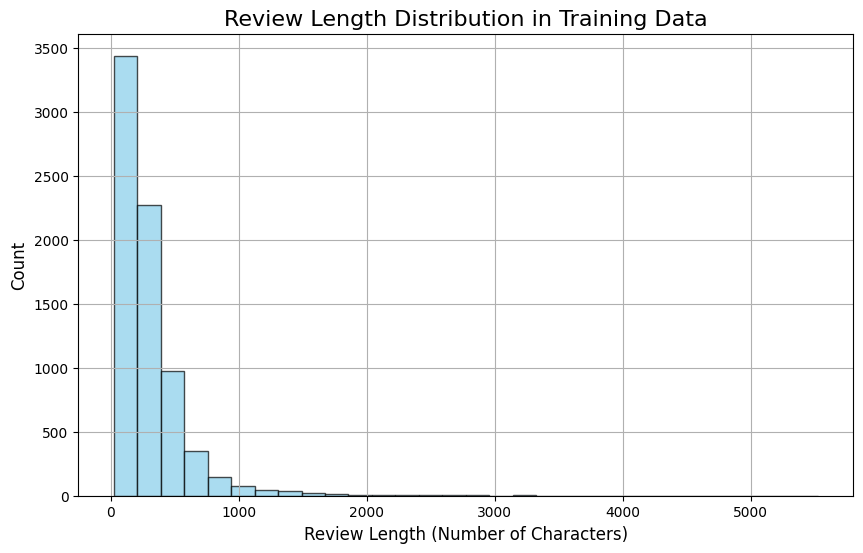


Review Length Statistics:
count    7401.000000
mean      300.926632
std       285.235376
min        24.000000
25%       133.000000
50%       223.000000
75%       373.000000
max      5525.000000
Name: review_length, dtype: float64


<ipython-input-21-87f7c3a0d6cc>:31: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




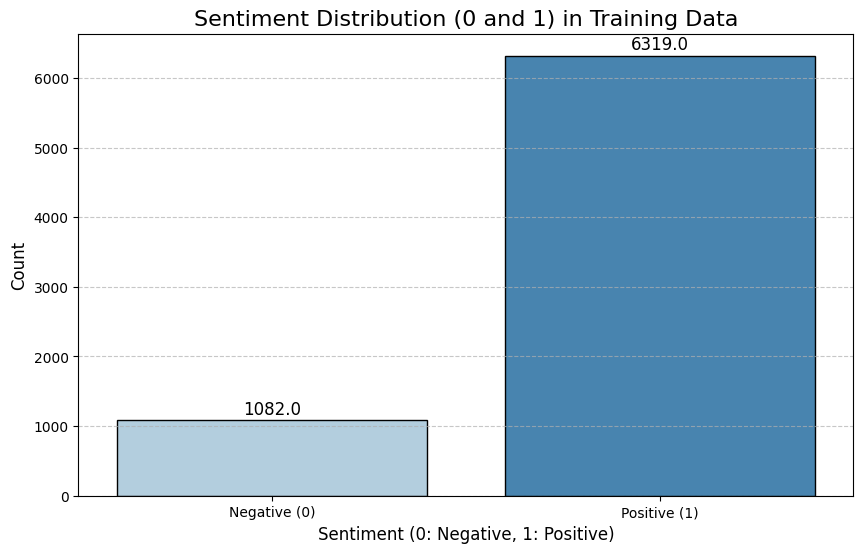


Sentiment Counts:
sentiments
1    6319
0    1082
Name: count, dtype: int64


In [21]:
train_path = '/content/drive/My Drive/AI DM PROJECT/train.json'
if os.path.exists(train_path):
  print("File founded")
  df = pd.read_json(train_path)
  print(f"Data shape: {df.shape}")
  print("\nFirst few rows:")
  print(df.head(2))
  train_df = df
else:
  print("File not founded")

if 'reviews' in train_df.columns:
    train_df['review_length'] = train_df['reviews'].apply(len)

    plt.figure(figsize=(10, 6))
    plt.hist(train_df['review_length'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)

    plt.title('Review Length Distribution in Training Data', fontsize=16)
    plt.xlabel('Review Length (Number of Characters)', fontsize=12)
    plt.ylabel('Count', fontsize=12)  # Set y-axis label to 'Count'
    plt.grid(True)
    plt.show()

    print("\nReview Length Statistics:")
    print(train_df['review_length'].describe())
else:
    print("The 'reviews' column is not present in the data.")

if 'sentiments' in train_df.columns:
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(data=train_df, x='sentiments', palette='Blues', edgecolor='black')

    for p in ax.patches:
        ax.annotate(f'{p.get_height()}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color='black',
                    xytext=(0, 8), textcoords='offset points')

    plt.title('Sentiment Distribution (0 and 1) in Training Data', fontsize=16)
    plt.xlabel('Sentiment (0: Negative, 1: Positive)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.xticks([0, 1], ['Negative (0)', 'Positive (1)'])
    plt.show()

    sentiment_counts = train_df['sentiments'].value_counts()
    print("\nSentiment Counts:")
    print(sentiment_counts)
else:
    print("The 'sentiments' column is not present in the data.")

## Step 3: Clean Data


In [22]:
if train_df is not None:
    print("Data Info:")
    print(train_df.info())

    print("\nMissing Values:")
    print(train_df.isnull().sum())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7401 entries, 0 to 7400
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   reviews        7401 non-null   object
 1   sentiments     7401 non-null   int64 
 2   review_length  7401 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 173.6+ KB
None

Missing Values:
reviews          0
sentiments       0
review_length    0
dtype: int64


In [23]:
class TextCleaner:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()

        self.stop_words = set(stopwords.words('english')) - {
            'not', 'no', 'nor',
            'very', 'too',
            'but', 'however',
            'above', 'below',
            'few', 'more',
            'most', 'least',
            'should', 'would'
        }

        self.contractions = {
            "ain't": "is not",
            "aren't": "are not",
            "can't": "cannot",
            "couldn't": "could not",
            "didn't": "did not",
            "doesn't": "does not",
            "don't": "do not",
            "hadn't": "had not",
            "hasn't": "has not",
            "haven't": "have not",
            "he'd": "he would",
            "he'll": "he will",
            "he's": "he is",
            "i'd": "i would",
            "i'll": "i will",
            "i'm": "i am",
            "i've": "i have",
            "isn't": "is not",
            "it's": "it is",
            "let's": "let us",
            "mightn't": "might not",
            "mustn't": "must not",
            "shan't": "shall not",
            "she'd": "she would",
            "she'll": "she will",
            "she's": "she is",
            "shouldn't": "should not",
            "that's": "that is",
            "there's": "there is",
            "they'd": "they would",
            "they'll": "they will",
            "they're": "they are",
            "they've": "they have",
            "wasn't": "was not",
            "we'd": "we would",
            "we're": "we are",
            "weren't": "were not",
            "we've": "we have",
            "what'll": "what will",
            "what're": "what are",
            "what's": "what is",
            "what've": "what have",
            "where's": "where is",
            "who'd": "who would",
            "who'll": "who will",
            "who're": "who are",
            "who's": "who is",
            "who've": "who have",
            "won't": "will not",
            "wouldn't": "would not",
            "you'd": "you would",
            "you'll": "you will",
            "you're": "you are",
            "you've": "you have"
        }

        self.preserve_terms = {
            'x', 'xl', 'xxl', 'xs', 's', 'm', 'l',
            '3d', '2d',
            'uk', 'us', 'eu',
            'mm', 'cm', 'in',
            'v1', 'v2', 'v3',
        }

    def expand_contractions(self, text):
        """Expand contractions in text."""
        for contraction, expansion in self.contractions.items():
            text = text.replace(contraction, expansion)
        return text

    def clean_text(self, text, lemmatize=True):
        """
        Clean text with options for different levels of processing.

        Args:
            text (str): Input text
            lemmatize (bool): Whether to apply lemmatization

        Returns:
            str: Cleaned text
        """
        if not isinstance(text, str):
            return ""

        text = text.lower()

        text = self.expand_contractions(text)

        text = re.sub(r'(\d+)x(\d+)', r'\1 by \2', text)
        text = re.sub(r'(\d+)ml', r'\1 ml', text)
        text = re.sub(r'(\d+)cm', r'\1 cm', text)
        text = re.sub(r'(\d+)mm', r'\1 mm', text)
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        text = re.sub(r'\S+@\S+', '', text)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'\n+', ' ', text)
        text = text.translate(str.maketrans('', '', string.punctuation.replace('-', '')))

        words = word_tokenize(text)

        cleaned_words = []
        for word in words:
            if word.lower() in self.preserve_terms:
                cleaned_words.append(word)
                continue

            if word not in self.stop_words:
                if lemmatize:
                    word = self.lemmatizer.lemmatize(word)
                cleaned_words.append(word)

        text = ' '.join(cleaned_words)
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def process_reviews(self, reviews, show_samples=5):
        """Process a series of reviews and optionally show samples."""
        cleaned_reviews = []

        for i, review in enumerate(reviews):
            cleaned = self.clean_text(review)
            cleaned_reviews.append(cleaned)

            if show_samples and i < show_samples:
                print(f"\nOriginal: {review[:100]}...")
                print(f"Cleaned:  {cleaned[:100]}...")

        return cleaned_reviews

cleaner = TextCleaner()

if 'train_df' in locals():
    print("\nProcessing training data:")
    train_df['cleaned_reviews'] = cleaner.process_reviews(train_df['reviews'])


Processing training data:

Original: I bought this belt for my daughter in-law for Christmas and she loved it...
Cleaned:  bought belt daughter in-law christmas loved...

Original: The size was perfect and so was the color.  It looked just like it did on the web page:)...
Cleaned:  size perfect color looked like web page...

Original: Fits and feels good, esp. for doing a swim race.  Highly recommend this.  

Be careful when wearing ...
Cleaned:  fit feel good esp swim race highly recommend careful wearing board short velcro zipper strap materia...

Original: These socks are absolutely the best. I take pilates classes and if it is hot your feet can slip off ...
Cleaned:  sock absolutely best take pilate class hot foot slip mat not good in middle side plankanyway sock ke...

Original: Thank you so much for the speedy delivery they came in time for the rehearsal dinner.  I loved the r...
Cleaned:  thank much speedy delivery came in time rehearsal dinner loved red silk neck tie really ma

## Step 4: Apply Vectorizer

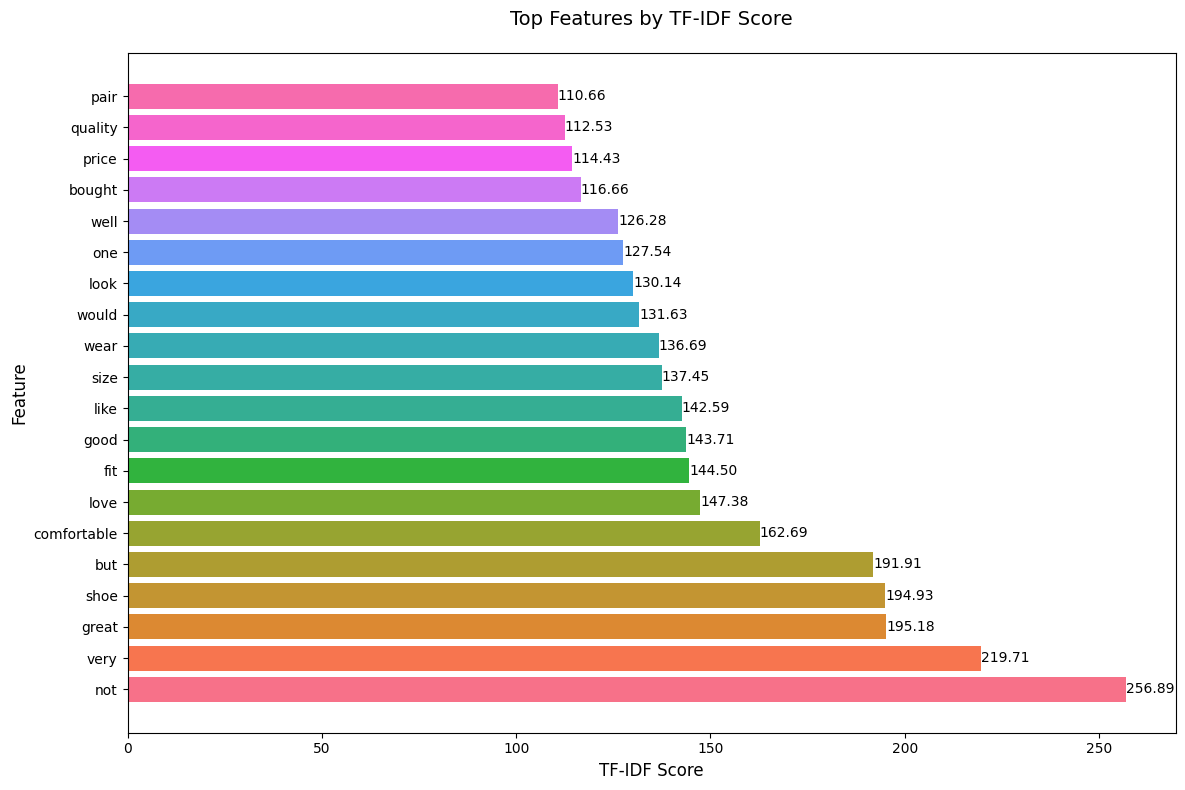


Top 20 meaningful features:
not: 256.8896
very: 219.7094
great: 195.1815
shoe: 194.9337
but: 191.9088
comfortable: 162.6869
love: 147.3764
fit: 144.5025
good: 143.7132
like: 142.5923
size: 137.4541
wear: 136.6914
would: 131.6324
look: 130.1360
one: 127.5425
well: 126.2767
bought: 116.6608
price: 114.4255
quality: 112.5339
pair: 110.6591


In [24]:
class AdvancedVectorizer:
    def __init__(self,
                 max_features=5000,
                 ngram_range=(1, 3),
                 max_df=0.85,
                 min_df=2,
                 custom_stop_words=None):
        self.max_features = max_features
        self.ngram_range = ngram_range
        self.max_df = max_df
        self.min_df = min_df
        self.custom_stop_words = custom_stop_words or set()
        self.fitted = False

        self.min_word_length = 3
        self.max_word_length = 25

        self.pipeline = self._create_pipeline()

    def _is_valid_feature(self, feature):
        """Check if a feature is valid based on enhanced criteria"""
        if re.match(r'^\d+$', feature):
            return False

        if len(feature) < self.min_word_length or len(feature) > self.max_word_length:
            return False

        if sum(c.isdigit() for c in feature) > len(feature) * 0.5:
            return False

        if not any(c.isalpha() for c in feature):
            return False

        return True

    def _create_pipeline(self):
        """Create sklearn pipeline with enhanced TF-IDF"""
        token_pattern = r'(?u)\b[A-Za-z][A-Za-z0-9-_\.]{2,}\b'

        return Pipeline([
            ('tfidf', TfidfVectorizer(
                max_features=self.max_features,
                ngram_range=self.ngram_range,
                max_df=self.max_df,
                min_df=self.min_df,
                stop_words=list(set(self._get_stop_words() + list(self.custom_stop_words))),
                sublinear_tf=True,
                norm='l2',
                smooth_idf=True,
                strip_accents='unicode',
                analyzer='word',
                token_pattern=token_pattern
            ))
        ])

    def _get_stop_words(self):
        """Get enhanced stopwords list"""
        stop_words = list(stopwords.words('english'))

        preserve_words = {
            'not', 'no', 'nor', 'very', 'too', 'only', 'but',
            'more', 'most', 'least', 'better', 'worse',
            'good', 'bad', 'great', 'poor', 'excellent', 'terrible',
            'big', 'small', 'large', 'tiny', 'huge',
            'expensive', 'cheap', 'worth', 'price',
            'quality', 'size', 'color', 'fit', 'material'
        }

        return [w for w in stop_words if w not in preserve_words]

    def fit(self, texts):
        """Fit the vectorizer to the texts"""
        self.pipeline.fit(texts)
        self.fitted = True
        self.feature_names = self.pipeline.named_steps['tfidf'].get_feature_names_out()
        return self

    def transform(self, texts):
        """Transform texts using the fitted pipeline"""
        if not self.fitted:
            raise ValueError("The vectorizer pipeline is not fitted yet. Call 'fit' first.")
        return self.pipeline.transform(texts)

    def fit_transform(self, texts):
        """Fit the vectorizer and transform the texts"""
        self.transformed_data = self.pipeline.fit_transform(texts)
        self.fitted = True
        self.feature_names = self.pipeline.named_steps['tfidf'].get_feature_names_out()
        return self.transformed_data

    def get_top_features(self, n_features=20):
        """Get top features with enhanced filtering"""
        if not self.fitted:
            raise ValueError("The vectorizer pipeline is not fitted yet. Call 'fit_transform' first.")

        tfidf = self.pipeline.named_steps['tfidf']
        feature_scores = np.asarray(self.transformed_data.sum(axis=0)).ravel()

        feature_score_pairs = [
            (feature, score)
            for feature, score in zip(self.feature_names, feature_scores)
            if self._is_valid_feature(feature)
        ]

        sorted_pairs = sorted(feature_score_pairs, key=lambda x: x[1], reverse=True)
        return sorted_pairs[:n_features]

    def visualize_top_features(self, n_features=20):
        """Visualize top features with enhanced formatting"""
        if not self.fitted:
            raise ValueError("The vectorizer pipeline is not fitted yet. Call 'fit_transform' first.")

        top_features = self.get_top_features(n_features)

        plt.figure(figsize=(12, 8))
        colors = sns.color_palette("husl", n_colors=n_features)

        bars = plt.barh([feature for feature, _ in top_features],
                       [score for _, score in top_features],
                       color=colors)

        plt.title('Top Features by TF-IDF Score', fontsize=14, pad=20)
        plt.xlabel('TF-IDF Score', fontsize=12)
        plt.ylabel('Feature', fontsize=12)

        for bar in bars:
            width = bar.get_width()
            plt.text(width, bar.get_y() + bar.get_height()/2,
                    f'{width:.2f}',
                    ha='left', va='center', fontsize=10)

        plt.tight_layout()
        plt.show()

try:
    vectorizer = AdvancedVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        max_df=0.7,
        min_df=5,
        custom_stop_words={
            'custom', 'stopwords', 'here',
            'thing', 'stuff', 'item', 'ones'
        }
    )

    transformed_data = vectorizer.fit_transform(train_df['cleaned_reviews'])

    transformed_df = pd.DataFrame(
        transformed_data.toarray(),
        columns=[f'feature_{i}' for i in range(transformed_data.shape[1])]
    )

    vectorizer.visualize_top_features()

    top_features = vectorizer.get_top_features(20)
    print("\nTop 20 meaningful features:")
    for feature, score in top_features:
        print(f"{feature}: {score:.4f}")

    X_train, X_val, y_train, y_val = train_test_split(
        transformed_data, train_df['sentiments'],
        test_size=0.2, random_state=42
    )

except NameError:
    print(NameError)


## Step 5: Implementing Feedforward Neural Network Classifier


Epoch [1/30], Train Loss: 0.6782, Train Acc: 62.48%, Val Loss: 0.4716, Val Acc: 88.86%
Epoch [2/30], Train Loss: 0.4591, Train Acc: 79.36%, Val Loss: 0.2797, Val Acc: 91.69%
Epoch [3/30], Train Loss: 0.3019, Train Acc: 88.63%, Val Loss: 0.2158, Val Acc: 92.91%
Epoch [4/30], Train Loss: 0.2075, Train Acc: 92.72%, Val Loss: 0.2061, Val Acc: 92.78%
Epoch [5/30], Train Loss: 0.1636, Train Acc: 94.21%, Val Loss: 0.2163, Val Acc: 92.57%
Epoch [6/30], Train Loss: 0.1342, Train Acc: 95.39%, Val Loss: 0.2221, Val Acc: 92.91%
Epoch [7/30], Train Loss: 0.1080, Train Acc: 96.27%, Val Loss: 0.2415, Val Acc: 92.10%
Epoch [8/30], Train Loss: 0.0996, Train Acc: 96.64%, Val Loss: 0.2470, Val Acc: 92.44%
Epoch [9/30], Train Loss: 0.0872, Train Acc: 97.01%, Val Loss: 0.2576, Val Acc: 92.10%
Epoch [10/30], Train Loss: 0.0626, Train Acc: 97.91%, Val Loss: 0.2745, Val Acc: 92.17%
Epoch [11/30], Train Loss: 0.0636, Train Acc: 97.60%, Val Loss: 0.2928, Val Acc: 91.83%
Epoch [12/30], Train Loss: 0.0610, Train 

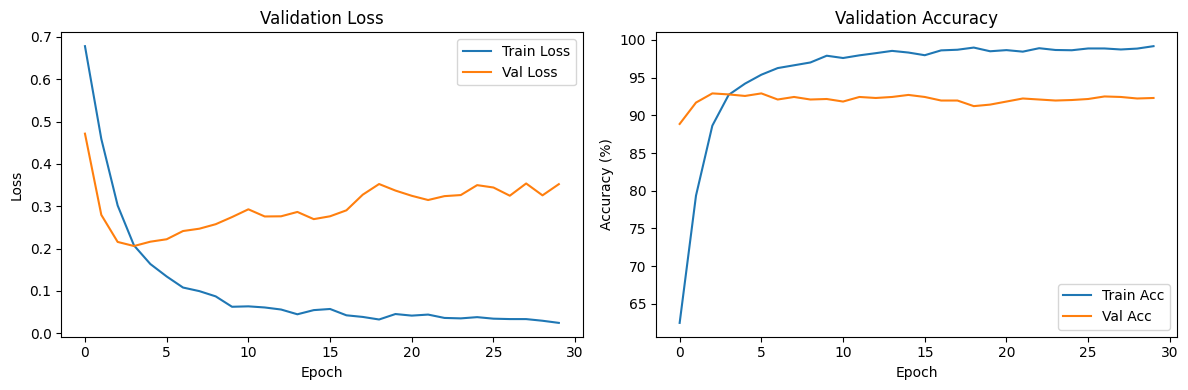

maximum accuracy:  92.91 %
high epoch:  3


In [31]:
class SentimentDataset(Dataset):
    def __init__(self, features, labels=None):
        features_dense = features.toarray()
        self.features = torch.FloatTensor(features_dense)
        self.labels = torch.LongTensor(labels.values) if labels is not None else None  # Convert Series to NumPy array

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if self.labels is not None:
            return self.features[idx], self.labels[idx]
        else:
            return self.features[idx]

class SentimentClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128], dropout_rate=0.3):
        super(SentimentClassifier, self).__init__()

        layers = []
        prev_dim = input_dim

        for dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, dim),
                nn.ReLU(),
                nn.BatchNorm1d(dim),
                nn.Dropout(dropout_rate)
            ])
            prev_dim = dim

        layers.append(nn.Linear(prev_dim, 2))  # 2 classes: positive and negative

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class SentimentAnalyzer:
    def __init__(self,
                 hidden_dims=[256, 128],
                 dropout_rate=0.3,
                 learning_rate=0.001,
                 batch_size=32,
                 num_epochs=10,
                 device='cuda' if torch.cuda.is_available() else 'cpu'):

        self.hidden_dims = hidden_dims
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.device = device
        self.model = None
        self.history = {'train_loss': [], 'val_loss': [],
                       'train_acc': [], 'val_acc': []}

    def create_data_loaders(self, X_train, y_train, X_val=None, y_val=None):
        """Create training and validation data loaders"""
        train_dataset = SentimentDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        val_loader = None
        if X_val is not None and y_val is not None:
            val_dataset = SentimentDataset(X_val, y_val)
            val_loader = DataLoader(val_dataset, batch_size=self.batch_size)

        return train_loader, val_loader

    def train(self, X_train, y_train, X_val=None, y_val=None):
        """Train the sentiment classifier"""
        input_dim = X_train.shape[1]
        self.model = SentimentClassifier(input_dim, self.hidden_dims, self.dropout_rate).to(self.device)

        train_loader, val_loader = self.create_data_loaders(X_train, y_train, X_val, y_val)

        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(self.num_epochs):
            self.model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0

            for batch_features, batch_labels in train_loader:
                batch_features = batch_features.to(self.device)
                batch_labels = batch_labels.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(batch_features)
                loss = criterion(outputs, batch_labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_total += batch_labels.size(0)
                train_correct += (predicted == batch_labels).sum().item()

            train_loss = train_loss / len(train_loader)
            train_acc = 100 * train_correct / train_total

            if val_loader is not None:
                val_loss, val_acc = self.evaluate(val_loader, criterion)
                print(f'Epoch [{epoch+1}/{self.num_epochs}], '
                      f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
                      f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

                self.history['val_loss'].append(val_loss)
                self.history['val_acc'].append(val_acc)
            else:
                print(f'Epoch [{epoch+1}/{self.num_epochs}], '
                      f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')

            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)

    def evaluate(self, data_loader, criterion):
        """Evaluate the model on the given data loader"""
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for features, labels in data_loader:
                features = features.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(features)
                loss = criterion(outputs, labels)
                total_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        return total_loss / len(data_loader), 100 * correct / total

    def predict(self, X):
        """Make predictions on new data"""
        self.model.eval()
        dataset = SentimentDataset(X)
        data_loader = DataLoader(dataset, batch_size=self.batch_size)
        predictions = []
        all_probabilities = []

        with torch.no_grad():
            for features in data_loader:
                features = features.to(self.device)
                outputs = self.model(features)
                probabilities = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(probabilities.data, 1)

                predictions.extend(predicted.cpu().numpy())
                all_probabilities.extend(probabilities.cpu().numpy())

        return np.array(predictions), np.array(all_probabilities)

    def plot_training_history(self):
        high_epoch = 0
        max_accuracy = 0
        index = 1
        """Plot training history"""
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(self.history['train_loss'], label='Train Loss')
        if 'val_loss' in self.history and self.history['val_loss']:
            plt.plot(self.history['val_loss'], label='Val Loss')
        plt.title('Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.history['train_acc'], label='Train Acc')
        if 'val_acc' in self.history and self.history['val_acc']:
            plt.plot(self.history['val_acc'], label='Val Acc')
            for index, accuracy in enumerate(self.history['val_acc']):
              if accuracy > max_accuracy:
                  max_accuracy = accuracy
                  high_epoch = index + 1

        plt.title('Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()

        plt.tight_layout()
        plt.show()

        print("maximum accuracy: ", round(max_accuracy, 2), "%")
        print("high epoch: ", high_epoch)


    def plot_interactive_training_history(self):
        """Create an interactive training history plot using Plotly"""
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Loss Curves', 'Accuracy Curves',
                          'Loss Distribution', 'Accuracy Progression')
        )

        fig.add_trace(
            go.Scatter(y=self.history['train_loss'], name='Train Loss',
                      line=dict(color='blue', width=2)), row=1, col=1)
        if self.history['val_loss']:
            fig.add_trace(
                go.Scatter(y=self.history['val_loss'], name='Val Loss',
                          line=dict(color='red', width=2)), row=1, col=1)

        fig.add_trace(
            go.Scatter(y=self.history['train_acc'], name='Train Acc',
                      line=dict(color='green', width=2)), row=1, col=2)
        if self.history['val_acc']:
            fig.add_trace(
                go.Scatter(y=self.history['val_acc'], name='Val Acc',
                          line=dict(color='orange', width=2)), row=1, col=2)

        fig.add_trace(
            go.Histogram(x=self.history['train_loss'], name='Train Loss Dist',
                        nbinsx=20, histnorm='probability'), row=2, col=1)

        epochs = list(range(1, len(self.history['train_acc']) + 1))
        fig.add_trace(
            go.Scatter(x=epochs, y=self.history['train_acc'],
                      mode='lines+markers',
                      name='Accuracy Progress'), row=2, col=2)

        fig.update_layout(height=800, width=1200, showlegend=True,
                         title_text="Detailed Training Analysis")
        fig.show()

analyzer = SentimentAnalyzer(
    hidden_dims=[256, 128, 128],
    dropout_rate=0.6,
    learning_rate=0.0005,
    batch_size=32,
    num_epochs=30
)

analyzer.train(X_train, y_train, X_val, y_val)

analyzer.plot_training_history()
y_pred = analyzer.predict(X_val)
analyzer.plot_interactive_training_history()


## Step 6: Predict on Test Data

In [32]:
test_path = '/content/drive/My Drive/AI DM PROJECT/test.json'
if os.path.exists(test_path):
  print("Test file founded")
  df = pd.read_json(test_path)
  print(f"Data shape: {df.shape}")
  print("\nFirst few rows:")
  print(df.head(2))
  test_df = df
else:
  print("File not founded")

Test file founded
Data shape: (1851, 1)

First few rows:
                                             reviews
0  I bought 2 sleepers.  sleeper had holes in the...
1  I dare say these are just about the sexiest th...


Clean test data

In [33]:
if test_df is not None:
    print("Data Info:")
    print(test_df.info())

    print("\nMissing Values:")
    print(test_df.isnull().sum())

cleaner = TextCleaner()

if 'test_df' in locals():
    print("\nProcessing training data:")
    test_df['cleaned_reviews'] = cleaner.process_reviews(test_df['reviews'])


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1851 entries, 0 to 1850
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   reviews  1851 non-null   object
dtypes: object(1)
memory usage: 14.6+ KB
None

Missing Values:
reviews    0
dtype: int64

Processing training data:

Original: I bought 2 sleepers.  sleeper had holes in the arm pit area and the other sleeper had a whole where ...
Cleaned:  bought 2 sleeper sleeper hole in arm pit area sleeper whole neck trim should sewed real waste money...

Original: I dare say these are just about the sexiest things I've ever worn. Oh I've had and have G-strings, h...
Cleaned:  dare say sexiest thing ever worn oh g-string pretty skimpy one too but crotchless g-string masquradi...

Original: everything about the transaction (price, delivery time, quality of item) was great.  I wouldn't hesi...
Cleaned:  everything transaction price delivery time quality item great would not he

In [34]:
X_test_transformed = vectorizer.transform(test_df['cleaned_reviews'])
predictions, probabilities = analyzer.predict(X_test_transformed)

submission_df = pd.DataFrame({
    'reviews': test_df['reviews'],
    'cleaned_reviews': test_df['cleaned_reviews'],
    'sentiments': predictions,
    'probability_0': [prob[0] for prob in probabilities],
    'probability_1': [prob[1] for prob in probabilities]
})

submission_df.to_csv('submission.csv', index=False)

good_reviews_df = submission_df[submission_df['sentiments'] == 1]
bad_reviews_df = submission_df[submission_df['sentiments'] == 0]

good_reviews_df = good_reviews_df.sort_values(by='probability_1', ascending=True)
bad_reviews_df = bad_reviews_df.sort_values(by='probability_0', ascending=True)

good_reviews_df.to_csv('good_reviews.csv', index=False)
bad_reviews_df.to_csv('bad_reviews.csv', index=False)

print(submission_df.head(10))

                                             reviews  \
0  I bought 2 sleepers.  sleeper had holes in the...   
1  I dare say these are just about the sexiest th...   
2  everything about the transaction (price, deliv...   
3  Not bad for just a shirt.  Very durable, and m...   
4  These are truly wrinkle free and longer than t...   
5  I love naughty monkey! I'm so happy with their...   
6  I fell in love with this boot when I first saw...   
7  These shades are a great buy.  Fast shipping, ...   
8  There was no picture of this selection, so I g...   
9  This leather briefcase was exactly what I was ...   

                                     cleaned_reviews  sentiments  \
0  bought 2 sleeper sleeper hole in arm pit area ...           0   
1  dare say sexiest thing ever worn oh g-string p...           1   
2  everything transaction price delivery time qua...           1   
3  not bad shirt very durable matched team color ...           1   
4  truly wrinkle free longer average woman 

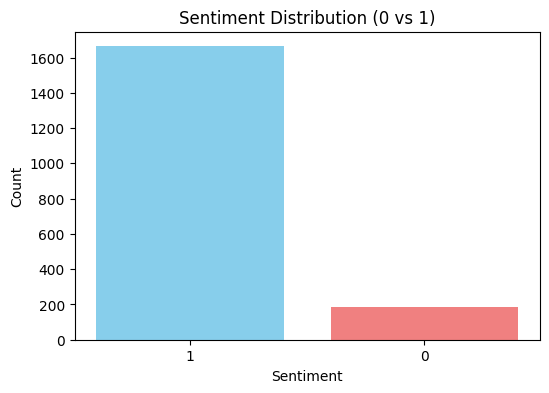

In [35]:
plt.figure(figsize=(6, 4))
sentiment_counts = pd.Series(predictions).value_counts()

plt.bar(sentiment_counts.index.astype(str), sentiment_counts.values, color=['skyblue', 'lightcoral'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution (0 vs 1)')
plt.xticks(sentiment_counts.index.astype(str))
plt.show()